## Day 2: Let the Tensors Flow!

Welcome to Day 2! Today, we start with our discussion with an introduction to TensorFlow followed by implementation of Numerical Integration techniques in TensorFlow.

### An Introduction to TensorFlow

TensorFlow is an open-source library that was developed by researchers and engineers in the Google Brain team. TensorFlow has a number of functions that make it particularly suitable for machine learning applications. However, it is primarily an interface for numerical computation. 

#### Why GPU/TPU vs CPU?

<img src="GPUvsCPU.svg" width="600"/>

The answer lies in the architecture:  
**CPU = Faster per Core Processing, Slow but Large Memory Buffer, Few Cores**  
**GPU/TPU = Slower Processing, Faster but Smaller Memory Buffer, Many Cores**  

Thus GPUs and TPUs are optimized for large number of simple calculations done parallely. The extent of this  parallelization makes it suitable for vector/tensor manipulation.

#### How TensorFlow works?

All computations in TensorFlow are specified as directed graphs (nodes connected by arrows) known as data flow graphs. Nodes are operations such as addition, multiplication etc. The incoming edges for each node are tensors (scalars, vectors, matrices and higher dimensional arrays), the actual values that are operated upon. The output is also a tensor that results from the computation. For example, consider the following computation where two vectors $a$ and $b$ serve as inputs to the node, a matrix multiplication operation, that produces a matrix $c$ as output.

<img src="matmul.svg" width="300"/>

Here, "matmul" is a node which represents the matrix multiplication operation. a and b are input matrices (2-D tensors) and c is the resultant matrix.

#### Implementing a computational graph in TensorFlow

In [1]:
# First, import Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow

import tensorflow as tf # for Tensorflow v1.x

# If using TensorFlow 2.x on CPU only or single GPU setup
# we suggest using TensorFlow Compat v1 instead as follows:

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# We suggest using TensorFlow v1.x compatibility for better multithreading 
# optimization and disabled eager execution in the earlier version 

# Defining Input Matrices
a_ = [[1.],[2.],[3.]] # a 3x1 column matrix 
b_ = [[1.,2.,3.]] # a 1x3 row matrix 

# Creating nodes in the computation graph 
a = tf.constant(a_, dtype=tf.float64) # 3x1 tensor
b = tf.constant(b_, dtype=tf.float64) # 1x3 tensor
c = tf.matmul(a, b) 

# If running TensorFlow 2.x without compat.v1, 
# c will hold the result of the computation.

# In TensorFlow v1.x, To run the graph, we need to create a session.
# Creating the session initializes the computational device.

sess = tf.Session() # start a session
output = sess.run(c) # compute the value of c
sess.close() # end the session

print(output)

[[1. 2. 3.]
 [2. 4. 6.]
 [3. 6. 9.]]


#### Efficient recursion with TensorFlow

To iterate over a list in Python, we used a "for" loop. However, when we implement the same in TensorFlow, putting operations inside a loop replicates the defined computation and chains them together. This results in a long repetitive computation graph with the same operations chained one after the other, resulting in large memory usage and slow computation. TensorFlow provides an alternative with the tf.scan() method.

Say, one wants to recursively apply a function on an initial value but the function takes in additional input at every recursive call, for example, to find the cumulative sum over a list. Every step adds a new element from the list to the last addition. The TensorFlow function tf.scan allows us to easily implement such an iterator.

In [2]:
# define the recursive function that takes in two values the
# accumulated value and the additional input from a list.
def recursive_addition(accumulator,new_element):
    return accumulator+new_element

# define the list over which we iterate
elems = np.array([1, 2, 3, 4, 5, 6])

# tf.scan takes in three inputs: the recursive function, the 
# list to iterate over and the initial value. If an initial 
# value is not provided, its taken as the first element of elems.

# accumulate with no initializer
cum_sum_a = tf.scan(recursive_addition, elems) 
# accumulate with initializer as the number 5
cum_sum_b = tf.scan(recursive_addition, elems, tf.constant(5))

# To automatically close the session after computation in TensorFlow 1.13, Use:
# with tf.Session() as sess:
#    output = sess.run(c) 
with tf.Session() as sess:
    output_a = sess.run(cum_sum_a)
    output_b = sess.run(cum_sum_b)

print(output_a)
print(output_b)

[ 1  3  6 10 15 21]
[ 6  8 11 15 20 26]


As an **Exercise** use tf.scan to compute the fibonacci sequence.

#### Euler Integration Function in TensorFlow
We now implement Euler's method using tf.scan to iterate over the time array. Note that the function scan\_func that defines each step of Euler's method, is now an input to tf.scan.

In [3]:
def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating): 
        # The datatype of any tensor t is accessed by t.dtype
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        
        time_delta_grid = t[1:] - t[:-1]  
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = dt*func(y,t)
            return y + dy
        
        # iterating over (a,b) where a and b are lists of same size
        # results in the ith accumulative step in tf.scan receiving
        # the ith elements of a and b zipped together
        
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0) 
        return tf.concat([[y0], y], axis=0)

def tf_odeint_euler(func, y0, t):
    
    # Convert input to TensorFlow Objects
    
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

#### Running the TensorFlow Euler Integrator

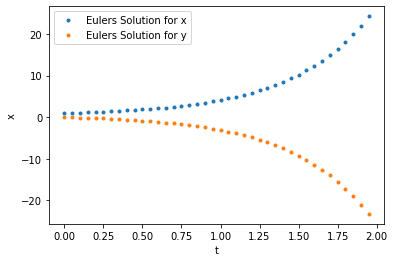

In [4]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_euler(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

plt.plot(t[::5],state.T[0,::5],".",label="Eulers Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="Eulers Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

#### RK4 Integration Function in TensorFlow

Now, we implement the RK4 integrator in TensorFlow. Note that here we replace the single step iterator used for the Euler's with a four step RK4 iterator. In addition, to make the code more modular, we define a function \_step\_func() that is called by scan\_func and calculates the next step of the RK4 integrator. The rest of the program remains the same as the Euler's method implemented above.

In [5]:
def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            return y + dy

        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def tf_odeint_rk4(func, y0, t):
    t = tf.convert_to_tensor(t, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    return _Tf_Integrator().integrate(func,y0,t)

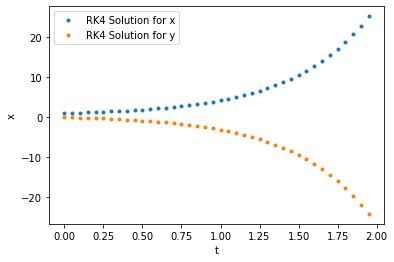

In [6]:
# Define a function using Tensorflow math operations. This creates a computational graph.

def f(X,t):
    # extracting a single value eg. X[0] returns a single value but
    # we require a tensor, so we extract a range with one element.
    x = X[0:1] 
    y = X[1:2]
    out = tf.concat([x-y,y-x],0)
    return out

y0 = tf.constant([1,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,2,epsilon)

# Define the final value (output of scan) that we wish to compute as a variable

state = tf_odeint_rk4(f,y0,t)

# Start a TF session and evaluate state
with tf.Session() as sess:
    state = sess.run(state)

plt.plot(t[::5],state.T[0,::5],".",label="RK4 Solution for x")
plt.plot(t[::5],state.T[1,::5],".",label="RK4 Solution for y")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

**Exercise** Simulate the non-linear Lorentz Attractor using Euler Method and RK4 on TensorFlow which is given by the equations:

$$\frac{dx}{dt}=\sigma(y-x)$$

$$\frac{dy}{dt}=x(\rho-z)-y$$

$$\frac{dz}{dt}=xy-\beta z$$

Use the values $\sigma =10$, $\beta =\frac{8}{3}$, $\rho =28$. You can try simulating this system at two nearby starting conditions and comment on the difference.

<img src="lorenz.svg" width="400"/>